In [7]:
import os
import numpy as np
from scipy import ndimage, misc
from sklearn.utils import shuffle
from sklearn.cross_validation import StratifiedKFold
from sklearn import datasets, svm, metrics

import skimage
from skimage.feature import local_binary_pattern
from skimage import data

import matplotlib.pyplot as plt
%matplotlib inline


directory = './Images/'

def load(seed=123):
    X = []
    y = []
    for i in range(5):
        cur_direct = directory + 'Cluster ' + str(i + 1) + '/'
        for jpg in os.listdir(cur_direct):
            # Flatten for simpler models, don't want to do this for CNN
#             X.append(misc.imresize(ndimage.imread(cur_direct + jpg, flatten=True), 0.2))
#             X.append((ndimage.imread(cur_direct + jpg, flatten=False)/255.))
            X.append(skimage.transform.resize(data.imread(cur_direct + jpg,
                                                          flatten=True,
                                                          as_grey=True), 
                                              (256, 256)))
#             X.append(data.imread(cur_direct + jpg,
#                                  flatten=True,
#                                  as_grey=True)
#                                  )
            y.append(i+1)
    
    X = np.asarray(X)
    y = np.asarray(y)
  
    X, y = shuffle(X, y, random_state=seed)  # shuffle train data
    
    X = X.astype('float32')
    y = y.astype('float32')
    return (X, y)
#     return (X, y)

X, y = load()

radius = 6
n_points = 4 * radius
METHOD = 'uniform'

X_ls = []

print(X.shape)

X_new = []

for i, x in enumerate(X):
    X_new.append(x.ravel())
    X_ls.append(np.asarray(local_binary_pattern(x, n_points, radius, METHOD)).ravel())

print(X.shape)
X_ls = np.asarray(X_ls)
X = np.asarray(X_new)

(347, 256, 256)
(347, 256, 256)


In [8]:
print(X.shape)
print(X_ls.shape)

(347, 65536)
(347, 65536)


In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca = PCA(n_components=4)
X_pca4 = pca.fit_transform(X)

pca = PCA(n_components=8)
X_pca8 = pca.fit_transform(X)

pca = PCA(n_components=16)
X_pca16 = pca.fit_transform(X)

pca = PCA(n_components=2)
X_ls_pca = pca.fit_transform(X_ls)

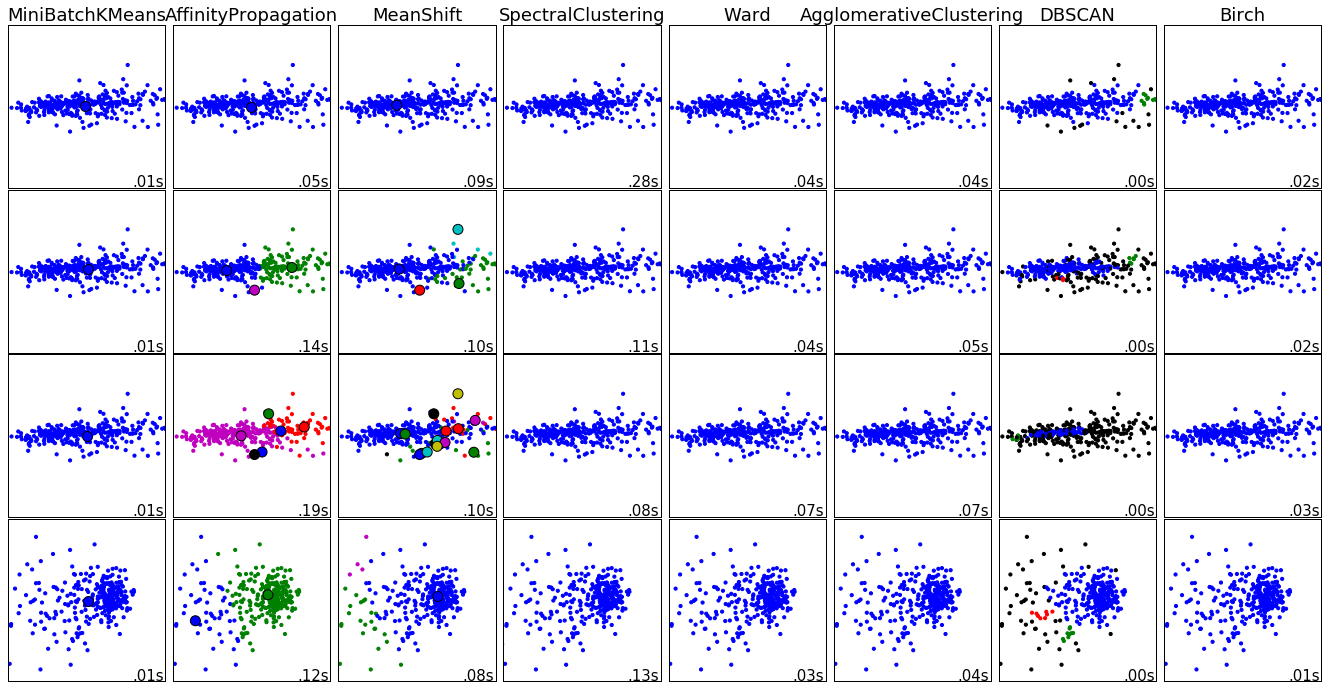

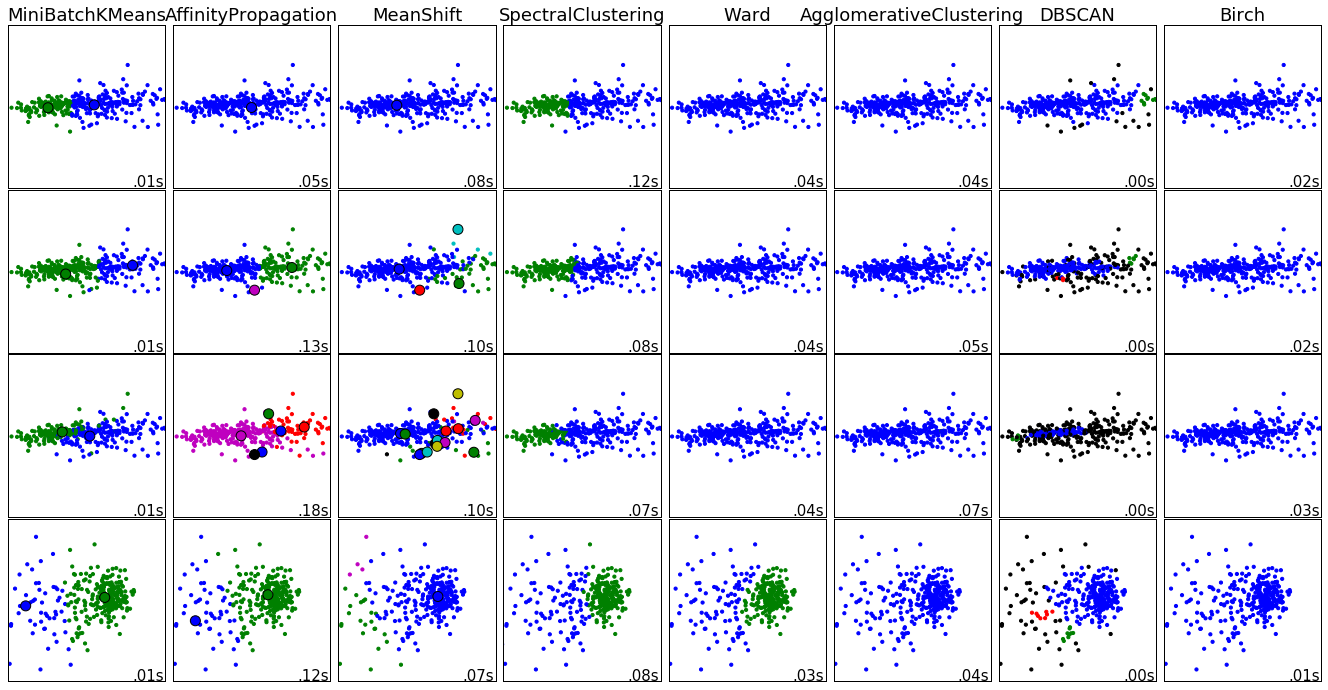

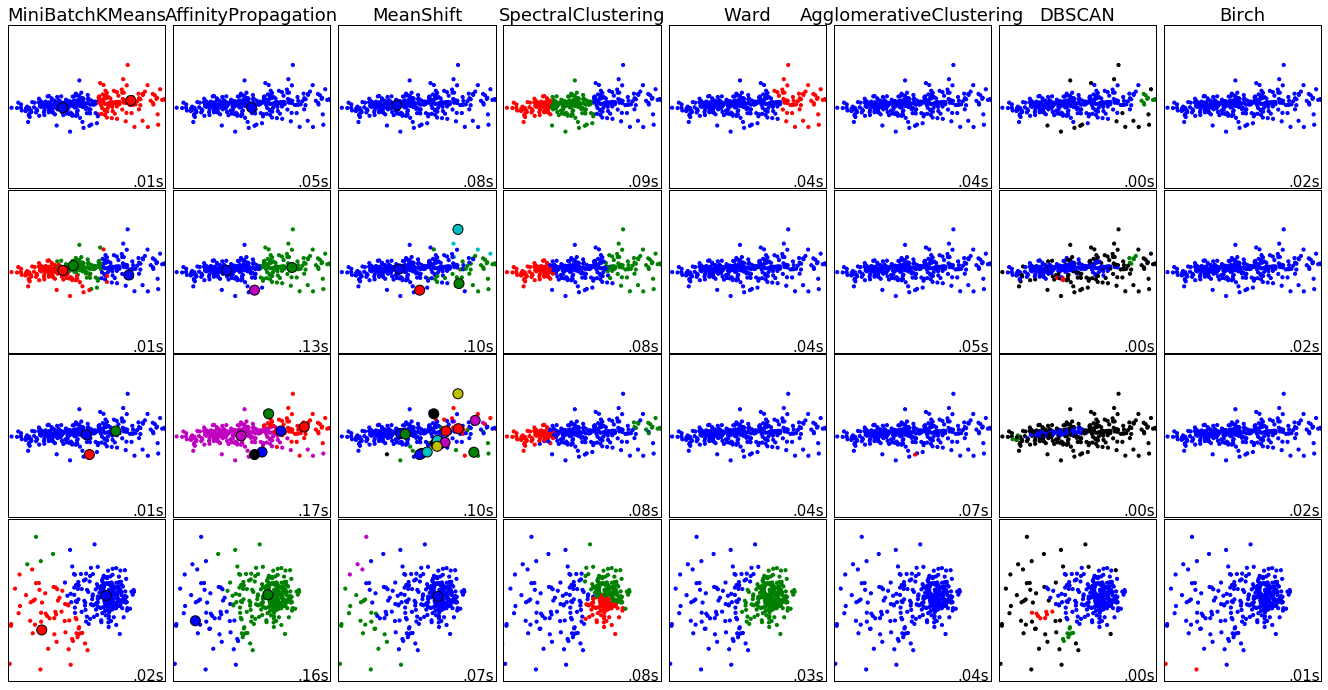

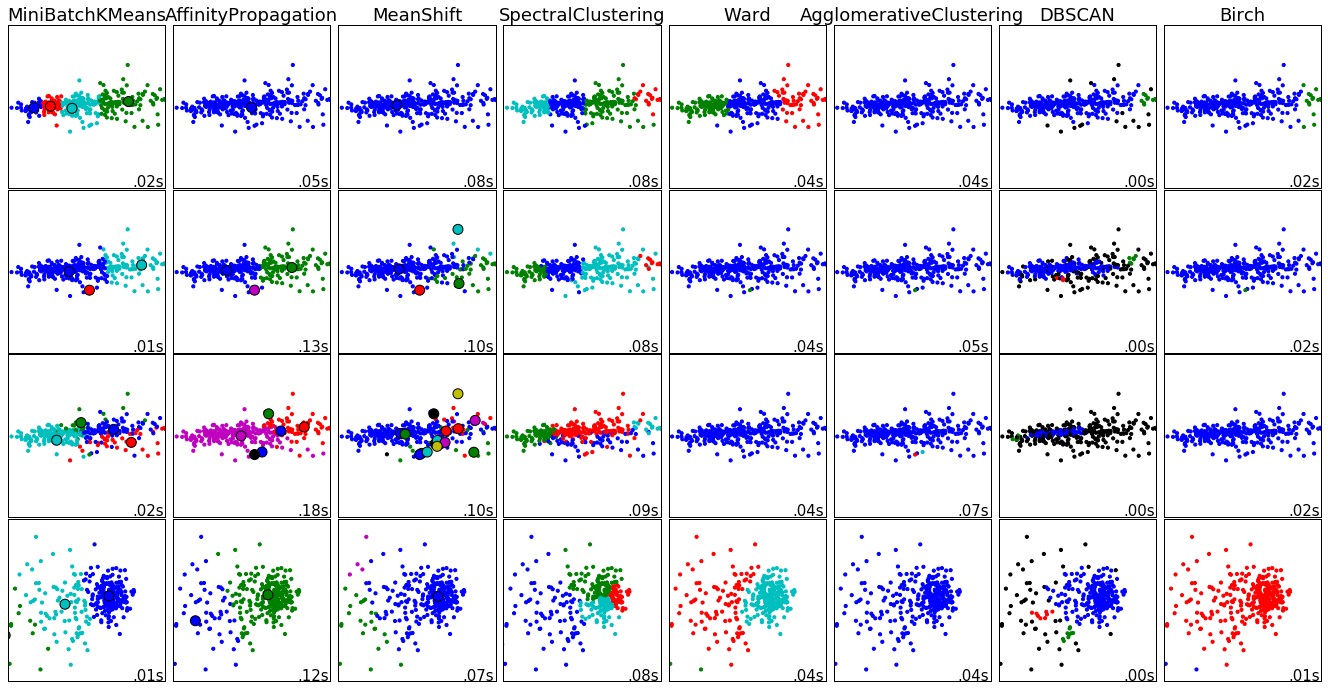

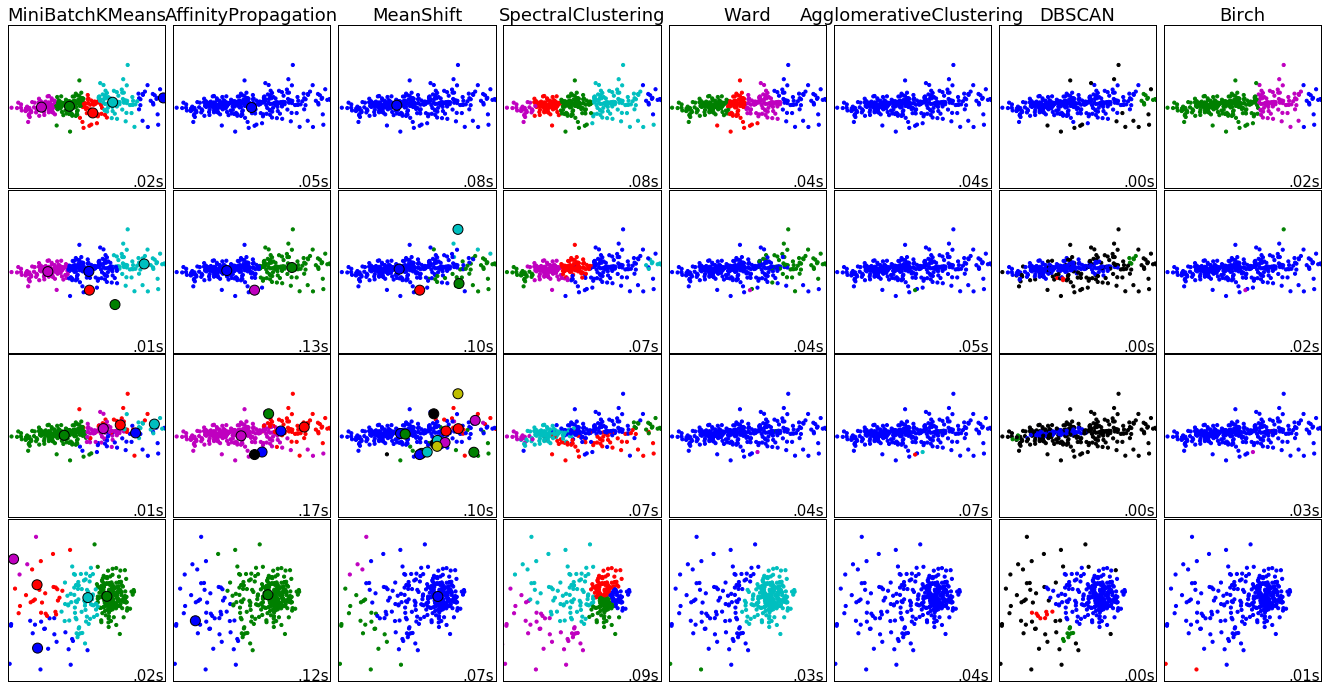

In [10]:
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import time

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'Birch']



for cluster_num in range(1, 6):
    plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    plot_num = 1

    # datasets = [(X, y), (X_ls, y), (X_pca, y)]
    datasets = [(X_pca, y), (X_pca4, y), (X_pca8, y), (X_ls_pca, y)]
    for i_dataset, dataset in enumerate(datasets):
        X, y = dataset
        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        # estimate bandwidth for mean shift
        bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)

        # create clustering estimators
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        two_means = cluster.MiniBatchKMeans(n_clusters=cluster_num)
        ward = cluster.AgglomerativeClustering(n_clusters=cluster_num, linkage='ward',
                                               connectivity=connectivity)
        spectral = cluster.SpectralClustering(n_clusters=cluster_num,
                                              eigen_solver='arpack',
                                              affinity="nearest_neighbors")
        dbscan = cluster.DBSCAN(eps=.2)
        affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                           preference=-200)

        average_linkage = cluster.AgglomerativeClustering(
            linkage="average", affinity="cityblock", n_clusters=cluster_num,
            connectivity=connectivity)

        birch = cluster.Birch(n_clusters=cluster_num)
        clustering_algorithms = [
            two_means, affinity_propagation, ms, spectral, ward, average_linkage,
            dbscan, birch]

        for name, algorithm in zip(clustering_names, clustering_algorithms):
    #         print(name, algorithm)
            # predict cluster memberships
            t0 = time.time()
            algorithm.fit(X)
            t1 = time.time()
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X)

            # plot
            plt.subplot(4, len(clustering_algorithms), plot_num)
            if i_dataset == 0:
                plt.title(name, size=18)
            plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

            if hasattr(algorithm, 'cluster_centers_'):
                centers = algorithm.cluster_centers_
                center_colors = colors[:len(centers)]
                plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
            plt.xlim(-2, 2)
            plt.ylim(-2, 2)
            plt.xticks(())
            plt.yticks(())
            plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                     transform=plt.gca().transAxes, size=15,
                     horizontalalignment='right')
            plot_num += 1

    plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier
skf = StratifiedKFold(y, n_folds=10)
for train, test in skf:
    classifier = RandomForestClassifier(n_estimators=1000, class_weight="balanced")
    classifier.fit(X_pca16[train], y[train])

    # Now predict the value of the digit on the second half:
    expected = y[test]
    predicted = classifier.predict(X_pca16[test])

    print("Classification report for classifier %s:\n%s\n"
          % (classifier, metrics.classification_report(expected, predicted)))
    print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False):
             precision    recall  f1-score   support

        1.0       0.33      0.20      0.25         5
        2.0       0.75      0.82      0.78        11
        3.0       0.00      0.00      0.00         4
        4.0       0.47      0.82      0.60        11
        5.0       0.00      0.00      0.00         5

avg / total       0.42      0.53      0.46        36


Confusion matrix:
[[1 0 1 3 0]
 [1 9 0 1 0]
 [0 0 0 4 0]
 [0 2 0 9 0]
 [1 1 1 2 0]]
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_dep

In [12]:
from sklearn.ensemble import RandomForestClassifier
skf = StratifiedKFold(y, n_folds=10)
for train, test in skf:
    classifier = RandomForestClassifier(n_estimators=1000, class_weight="balanced")
    classifier.fit(X_ls_pca[train], y[train])

    # Now predict the value of the digit on the second half:
    expected = y[test]
    predicted = classifier.predict(X_ls_pca[test])

    print("Classification report for classifier %s:\n%s\n"
          % (classifier, metrics.classification_report(expected, predicted)))
    print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False):
             precision    recall  f1-score   support

        1.0       0.33      0.40      0.36         5
        2.0       0.60      0.82      0.69        11
        3.0       0.00      0.00      0.00         4
        4.0       0.78      0.64      0.70        11
        5.0       0.20      0.20      0.20         5

avg / total       0.50      0.53      0.50        36


Confusion matrix:
[[2 1 0 2 0]
 [0 9 0 0 2]
 [1 1 0 0 2]
 [3 1 0 7 0]
 [0 3 1 0 1]]
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_dep